In [12]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import joblib

In [13]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

In [14]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.01
DATA = './data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv' 

TARGET_FET = 'apparent_temperature'
DROP_FEATURES = ['date']

MODEL_NAME = 'model_v1_sequential'
SAVE_PATH = './models'

In [15]:
df = pd.read_csv(DATA)
df['date'] = pd.to_datetime(df['date'])
df[TARGET_FET + '_next'] = df[TARGET_FET].shift(-1)
df = df.dropna().reset_index(drop=True)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+-----------------------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0_to_7cm |   soil_moisture_0_to_7cm |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |   apparent_temperature_next |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+-----------------------------|
|  0 | 2015-12-31 23:00:00+0

In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86927 entries, 0 to 86926
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   date                       86927 non-null  datetime64[ns, UTC]
 1   temperature_2m             86927 non-null  float64            
 2   relative_humidity_2m       86927 non-null  float64            
 3   apparent_temperature       86927 non-null  float64            
 4   surface_pressure           86927 non-null  float64            
 5   wind_direction_10m         86927 non-null  float64            
 6   wind_speed_10m             86927 non-null  float64            
 7   soil_temperature_0_to_7cm  86927 non-null  float64            
 8   soil_moisture_0_to_7cm     86927 non-null  float64            
 9   rain                       86927 non-null  float64            
 10  dew_point_2m               86927 non-null  float64            
 11  sn

In [17]:
print(df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    86927.000000          86927.000000          86927.000000   
mean        10.808056             74.093049              8.398302   
std          8.344982             16.129185             10.011739   
min        -17.650000             20.787464            -22.915014   
25%          4.265500             63.028407              0.251772   
50%         10.500000             76.759070              7.666973   
75%         17.300000             87.584000             16.339384   
max         36.550000            100.000000             37.904636   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      86927.000000        86927.000000    86927.000000   
mean        1001.472800          210.917864       12.196714   
std            8.660905           88.886009        6.454782   
min          968.225700            0.674022        0.000000   
25%          996.348800          139.981800        7.568566   


In [18]:
df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

df_len = len(df)

train_end = int(df_len * (1 - TEST_SIZE - VAL_SIZE))
val_end = int(df_len * (1 - TEST_SIZE))

train_df = df.iloc[:train_end].copy()
val_df = df.iloc[train_end:val_end].copy()
test_df = df.iloc[val_end:].copy()


print(f'Train size: {len(train_df)}')
print(f'Validation size: {len(val_df)}')
print(f'Test size: {len(test_df)}')

Train size: 52156
Validation size: 17385
Test size: 17386


In [19]:
scaler = StandardScaler()
feature_columns = [col for col in df.columns if col not in DROP_FEATURES]

scaler.fit(train_df[feature_columns])

train_df[feature_columns] = scaler.transform(train_df[feature_columns])
val_df[feature_columns] = scaler.transform(val_df[feature_columns])
test_df[feature_columns] = scaler.transform(test_df[feature_columns])

print(train_df.describe())

       temperature_2m  relative_humidity_2m  apparent_temperature  \
count    5.215600e+04          5.215600e+04          5.215600e+04   
mean     1.471329e-16         -2.163398e-16         -7.029681e-17   
std      1.000010e+00          1.000010e+00          1.000010e+00   
min     -3.410100e+00         -3.307181e+00         -3.126610e+00   
25%     -7.843926e-01         -6.836186e-01         -8.146785e-01   
50%     -4.104167e-02          1.572682e-01         -7.150839e-02   
75%      7.802413e-01          8.386210e-01          7.933060e-01   
max      3.088226e+00          1.608710e+00          2.950136e+00   

       surface_pressure  wind_direction_10m  wind_speed_10m  \
count      5.215600e+04        5.215600e+04    5.215600e+04   
mean       7.744365e-15       -1.662056e-16    2.070759e-17   
std        1.000010e+00        1.000010e+00    1.000010e+00   
min       -3.836846e+00       -2.366120e+00   -1.886263e+00   
25%       -5.945468e-01       -7.943948e-01   -7.170194e-01   


In [20]:
def extract_Xy(dataframe):
    X = dataframe.drop(columns=DROP_FEATURES+[TARGET_FET + '_next'])
    y = dataframe[TARGET_FET + '_next']
    return X, y

X_train, y_train = extract_Xy(train_df)
X_val, y_val = extract_Xy(val_df)
X_test, y_test = extract_Xy(test_df)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(52156, 13) (52156,)
(17385, 13) (17385,)
(17386, 13) (17386,)


In [21]:
model = tf.keras.Sequential(name=MODEL_NAME)
model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='mse', metrics=['mae'])

print(model.summary())

Model: "model_v1_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 3,009 (11.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
monitors = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.10, patience=5, min_lr=1e-6, verbose=1)
]

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=monitors)

Epoch 1/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0183 - mae: 0.0952 - val_loss: 0.0303 - val_mae: 0.1299 - learning_rate: 0.0100
Epoch 2/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0136 - mae: 0.0869 - val_loss: 0.0183 - val_mae: 0.1019 - learning_rate: 0.0100
Epoch 3/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0128 - mae: 0.0843 - val_loss: 0.0149 - val_mae: 0.0908 - learning_rate: 0.0100
Epoch 4/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0125 - mae: 0.0831 - val_loss: 0.0131 - val_mae: 0.0857 - learning_rate: 0.0100
Epoch 5/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0124 - mae: 0.0824 - val_loss: 0.0117 - val_mae: 0.0804 - learning_rate: 0.0100
Epoch 6/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0121 - mae: 0.0816 - val_loss: 0.0115 - val_mae: 0.0804 - learning_rate: 0.0100
Epoch 7/100
1630/1630 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0121 - mae: 0.0815 - val_loss: 0.0118 - val_mae: 0.0805 - learnin

In [23]:
os.makedirs(os.path.join(SAVE_PATH,MODEL_NAME), exist_ok=True)
model.save(os.path.join(SAVE_PATH, MODEL_NAME, 'model.keras'))
joblib.dump(scaler, os.path.join(SAVE_PATH, MODEL_NAME, 'scaler.pkl'))

['./models\\model_v1_sequential\\scaler.pkl']

=== TRAINING ===


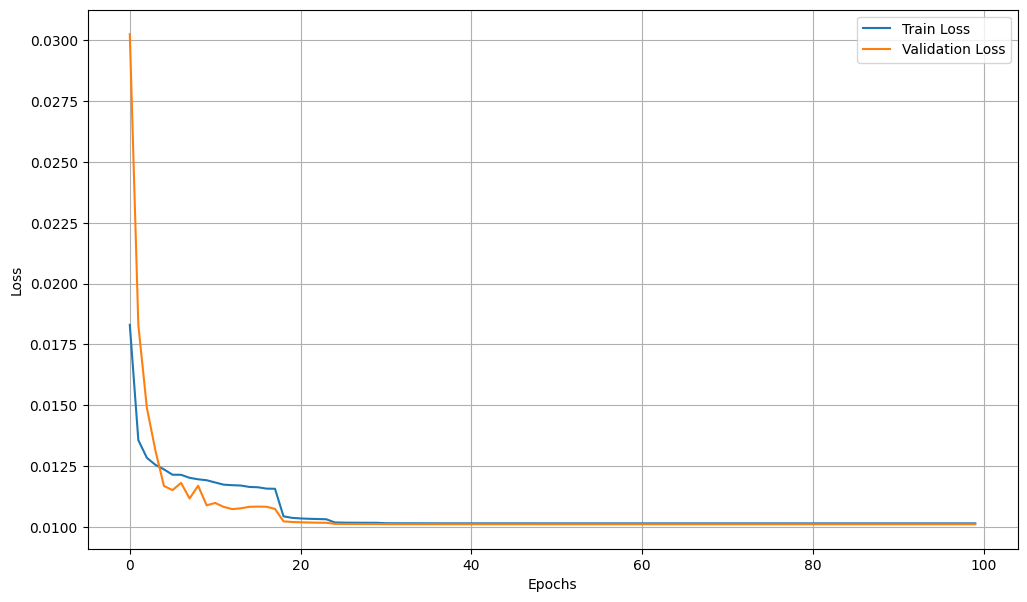

In [24]:
print("=== TRAINING ===")
plt.figure(figsize=(12, 7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
    

In [25]:
mae_scaled = model.evaluate(X_test, y_test)[1]

predictions = model.predict(X_test)
pred_rescaled = scaler.inverse_transform(np.hstack((X_test, predictions)))[:, -1]
test_y_rescaled = scaler.inverse_transform(np.hstack((X_test, y_test.values.reshape(-1, 1))))[:, -1]

print()
print("=== TEST ===")

mae = np.mean(np.abs(pred_rescaled - test_y_rescaled))
print(f'Test MAE on scaled data: {mae_scaled:.3f}')
print(f'Test MAE rescaled to original values: {mae:.3f}')

print()

comp_tab = pd.DataFrame({
    'Data': test_df['date'].values,
    'Predicted': pred_rescaled,
    'Actual': test_y_rescaled
})
comp_tab = comp_tab.sort_values(by='Data')

print(tabulate(comp_tab, headers='keys', tablefmt='psql'))

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0101 - mae: 0.0726
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step

=== TEST ===
Test MAE on scaled data: 0.073
Test MAE rescaled to original values: 0.726

+-------+---------------------+--------------+--------------+
|       | Data                |    Predicted |       Actual |
|-------+---------------------+--------------+--------------|
|  8714 | 2016-01-01 01:00:00 |  -8.09769    |  -8.06435    |
|  4662 | 2016-01-01 04:00:00 |  -6.23884    |  -5.76886    |
|  5758 | 2016-01-01 14:00:00 |  -2.86517    |  -3.12223    |
|   127 | 2016-01-01 17:00:00 |  -3.93609    |  -4.41444    |
|  3825 | 2016-01-01 19:00:00 |  -5.03203    |  -5.25043    |
|  4956 | 2016-01-01 21:00:00 |  -5.99206    |  -6.82818    |
|  4480 | 2016-01-02 01:00:00 |  -9.19834    | -10.2634     |
|  9839 | 2016-01-02 03:00:00 | -11.0688     | -12.4443     |
|  7090 | 2016-01-02 11:00:00 | -13.2636     | -13.1801     |
|  8264 | 2016-01-02 12:00:00 | -12.9008     | -12.90

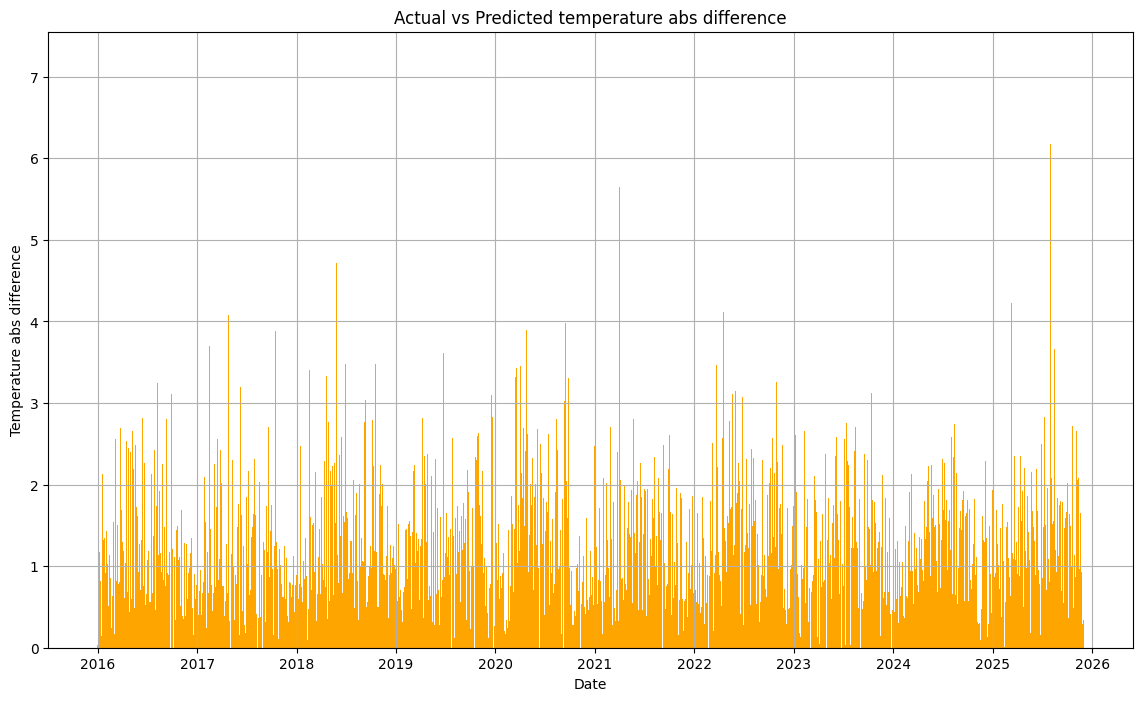

In [26]:
plt.figure(figsize=(14, 8))
diff = np.abs(comp_tab['Actual'] - comp_tab['Predicted'])
plt.bar(comp_tab['Data'], diff, color='orange')
plt.xlabel('Date')
plt.ylabel('Temperature abs difference')
plt.title('Actual vs Predicted temperature abs difference')
plt.grid()
plt.show()